# Lab 9: Grid Localization using Bayes Filter on the Virtual Robot

#### <span style="color:rgb(0,150,0)">It is recommended that you close any heavy-duty applications running on your system while working on this lab.</span>

#### This notebook showcases localization results of the **Localization** module (defined in *robot_interface.py*) for the virtual robot.

<hr>


In [1]:
# Automatically reload changes in python modules
%load_ext autoreload
%autoreload 2

# Import classes
from robot_interface import *

import time
import numpy as np
import rospy
from Traj import Trajectory

In [4]:
from gridmap import OccupancyGridMap
import matplotlib.pyplot as plt
from a_star import a_star
from utils import plot_path

In [12]:
# Instantiate VirtualRobot to communicate with the real robot
robot = VirtualRobot()

# Instantiate Mapper
# Start points for each line segment describing the map
start_points = np.array([[0,0],
                         [3.04,0],
                         [3.04,3.04],
                         [0,3.04],
                         [0,0],
                         [0,0.608],
                         [0.608,0.608],
                         [0.608,0.912],
                         [0,0.912],
                         [0,2.128],
                         [1.216,2.128],
                         [1.216,1.52],
                         [2.584,1.52],
                         [2.584,0.912],
                         [1.52,0.304]])

# End points for each line segment describing the map
end_points = np.array([  [3.04,0],
                         [3.04,3.04],
                         [0,3.04],
                         [0,0],
                         [0,0.608],
                         [0.608,0.608],
                         [0.608,0.912],
                         [0,0.912],
                         [0,2.128],
                         [1.216,2.128],
                         [1.216,1.52],
                         [2.584,1.52],
                         [2.584,0.912],
                         [1.52,0.304],
                         [0,0]])

# Requires a RealRobot object as input
mapper = Mapper(min_x=0, max_x=3.04, min_y=0, max_y=3.04, min_a=-180, max_a=180,
                cell_size_x=0.152, cell_size_y=0.152, cell_size_a=20,
                max_cells_x=20, max_cells_y=20, max_cells_a=18,
                ray_length=7, lines=[start_points, end_points], obs_per_cell=18, 
                robot=robot)
#mapper.populate_views()

# Instantiate Localization 
odom_trans_sigma = 0.33
odom_rot_sigma = 15
sensor_sigma = 0.11

# Requires a RealRobot object and a Mapper object as inputs
loc = Localization(robot, mapper, sensor_sigma, odom_trans_sigma, odom_rot_sigma)

# Visualize the map (described using line segments) in the plotter
loc.plotter.visualize_map()

Using python version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0] 

Initializing Node
Initializing Virtual Robot
Initializing beliefs with a Uniform Distribution
Uniform Belief with each cell value:  0.0001388888888888889


[[360 330]
 [359 330]
 [358 330]
 ...
 [283  86]
 [284  86]
 [285  86]]


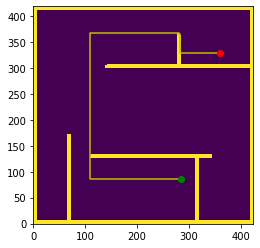

In [11]:
# load the map
gmap = OccupancyGridMap.from_png('maps/example_map_binary.png', 1)

# set a start and an end node (in meters)
start_node = (360.0, 330.0)
goal_node = (285.0, 86.0)

# run A*
path, path_px = a_star(start_node, goal_node, gmap, movement='4N')

gmap.plot()

if path:
    # plot resulting path in pixels over the map
    plot_path(path_px, loc)
else:
    print('Goal is not reachable')

    # plot start and goal points over the map (in pixels)
    start_node_px = gmap.get_index_from_coordinates(start_node[0], start_node[1])
    goal_node_px = gmap.get_index_from_coordinates(goal_node[0], goal_node[1])

    plt.plot(start_node_px[0], start_node_px[1], 'ro')
    plt.plot(goal_node_px[0], goal_node_px[1], 'go')

plt.show()

In [9]:
cx,cy,ca = mapper.to_map(0,2.128,0)
#mapper.get_views(cx,cy,ca)

# Bayes filter on the virtual robot
The cell below run the bayes filter algorithm for the pre-planned trajectory.

In [ ]:
# Reset Plots
robot.reset()
loc.plotter.reset_plot()

# Init Uniform Belief
loc.init_pose()

# Get Observation Data by executing a 360 degree rotation motion
loc.get_observation_data()

# Run Update Step
loc.update_step()
loc.print_update_stats(plot_data=True)
    
# Intialize the Trajectory object
traj = Trajectory(loc)

# Run through each motion steps
for t in range(0, traj.total_time_steps):

    print("\n\n-----------------", t, "-----------------")
    
    prev_odom, current_odom, prev_gt, current_gt = traj.execute_time_step(t)
    
    # Prediction Step
    loc.prediction_step(current_odom, prev_odom)
    loc.print_prediction_stats(plot_data=True)
    
    # Get Observation Data by executing a 360 degree rotation motion
    loc.get_observation_data()
    
    # Update Step    
    loc.update_step()
    loc.print_update_stats(plot_data=True)
    
        
    print("-------------------------------------")